In [52]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Activation, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from keras.layers.merge import concatenate
from keras import optimizers, regularizers
from keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from dataprep import get_vectors, get_data

import tensorflow as tf
import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings('ignore')

In [2]:
# To calculate on GPU
# https://github.com/tensorflow/tensorflow/issues/33721
TF_FORCE_GPU_ALLOW_GROWTH=1
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [3]:
# CONSTANTS
seed = 42

In [5]:
cmt_pos = pd.read_csv('../../data/prepared/no_trans_stem_pos.csv')
cmt_neg = pd.read_csv('../../data/prepared/no_trans_stem_neg.csv')
X, Y, vocab_size, emdedding_size = get_data(cmt_pos, cmt_neg, 0)
vectors = get_vectors(0).vectors
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=seed, test_size=0.3, stratify=Y, shuffle=True)
# check if the data is evenly split
import collections
print('Train labels: ', collections.Counter(y_train))
print('Test labels: ', collections.Counter(y_test))

Train labels:  Counter({1: 965, 0: 965})
Test labels:  Counter({1: 414, 0: 414})


In [6]:
# Cross validation setup
sk = StratifiedKFold(n_splits = 3, random_state = seed, shuffle = True) 

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, mode='min')

In [8]:
adamOptimizer = Adam(lr=0.001)

In [9]:
def plot_history(history_arrs, train, val, xlabel, ylabel, plot_title):
    if len(history_arrs) == 1:
        history = history_arrs[0]
        plt.plot(history['accuracy'])
        plt.plot(history['val_accuracy'])
        plt.title(plot_title)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()
    else:
        f, a = plt.subplots(1, len(history_arrs), figsize=(10,5))
        for idx, history in enumerate(history_arrs):
            # For Sine Function
            a[idx].plot(history[train])
            a[idx].plot(history[val])
            title = plot_title + ' ' + str(idx)
            a[idx].set_title(title)
            a[idx].set_xlabel(xlabel)
            a[idx].set_ylabel(ylabel)
            a[idx].legend(['Train', 'Validation'], loc='upper left')
        f.tight_layout()
        plt.show()

In [10]:
def run_test(model_func, X_train, y_train, embedding_layer):
    results = []
    histories = []
    for train_index, val_index in sk.split(X_train, y_train):
        Xtrain, Xval = X_train[train_index], X_train[val_index]
        ytrain, yval = y_train[train_index], y_train[val_index]
        model = model_func(embedding_layer)
        history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval), epochs=30, batch_size=16, verbose = 0, callbacks=[early_stopping])
        histories.append(history.history)
        loss, acc = model.evaluate(X_test, y_test, verbose = 0, batch_size = 16)
        results.append([loss, acc])
    results = np.array(results)
    return results, histories

In [26]:
def model_1(embedding_layer):
    model = Sequential()
    model.add(embedding_layer)
    model.add(Conv1D(128, 2))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(64))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer=adamOptimizer, metrics = ['accuracy'])
    return model

Cross-validation without predefined word vectors

Model 1 accuracy on the test data is 0.8104


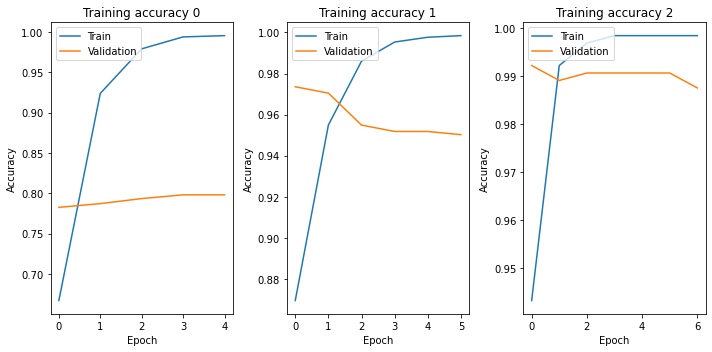

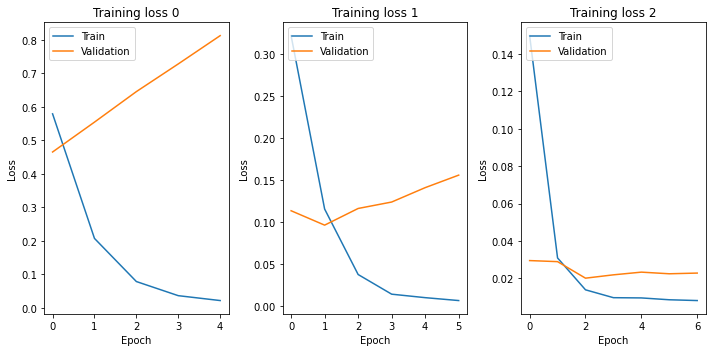

In [28]:
embedding_layer = Embedding(X.max()+1, 32, input_length=X.shape[1], trainable = True)
results, histories = run_test(model_1, X_train, y_train, embedding_layer)
print('Model 1 accuracy on the test data is %.4f' % results[:, 1].mean())

# Plots
# Accuracy
plot_history(histories, 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy') 
# Loss
plot_history(histories, 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss')

Cross-validation with word vectors

Model 1 accuracy on the test data is 0.7999


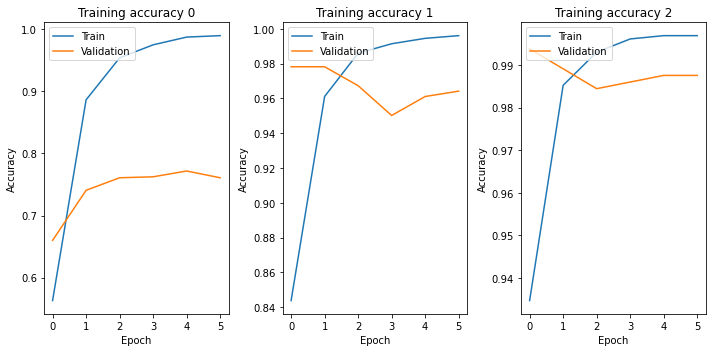

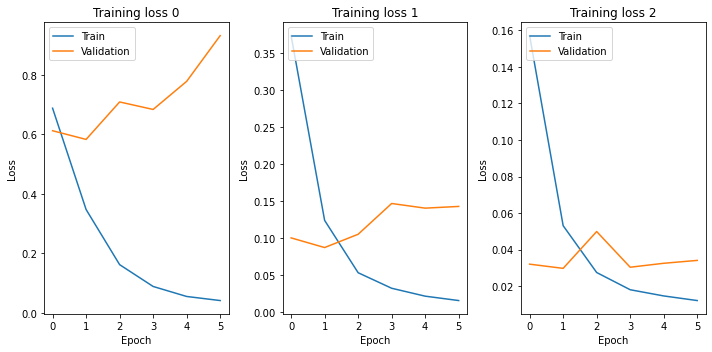

In [29]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=emdedding_size, weights=[vectors], trainable=True)
results, histories = run_test(model_1, X_train, y_train, embedding_layer)
print('Model 1 accuracy on the test data is %.4f' % results[:, 1].mean())

# Plots
# Accuracy
plot_history(histories, 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy') 
# Loss
plot_history(histories, 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss')

In [77]:
def model_2(embedding_layer):
    model = Sequential()
    model.add(embedding_layer)
    model.add(Conv1D(128, 2))
    model.add(MaxPooling1D(2))
    model.add(LSTM(128))
    model.add(Dense(32))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer=Adam(lr=0.001), metrics = ['accuracy'])
    return model

Cross-validation without predefined word vectors

Model 2 accuracy on the test data is 0.8092


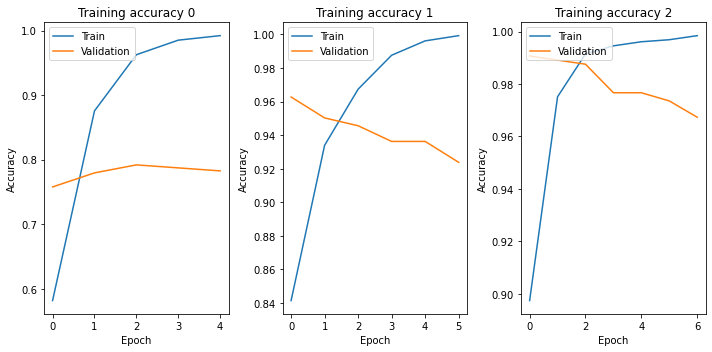

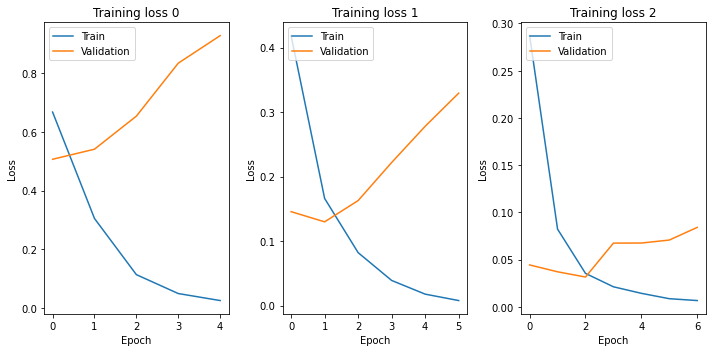

In [78]:
embedding_layer = Embedding(X.max()+1, 32, input_length=X.shape[1], trainable = True)
results, histories = run_test(model_2, X_train, y_train, embedding_layer)
print('Model 2 accuracy on the test data is %.4f' % results[:, 1].mean())

# Plots
# Accuracy
plot_history(histories, 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy') 
# Loss
plot_history(histories, 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss')

Cross-validation with word vectors

Model 2 accuracy on the test data is 0.7983


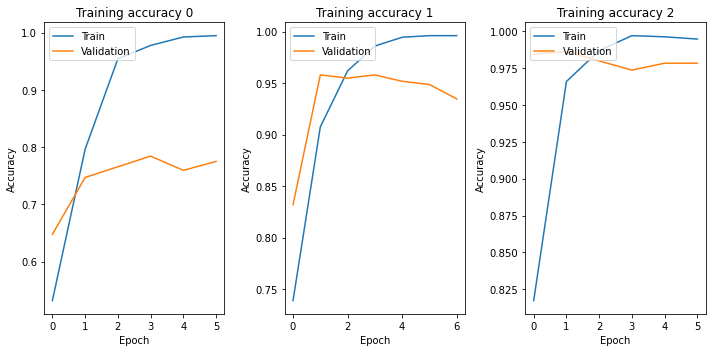

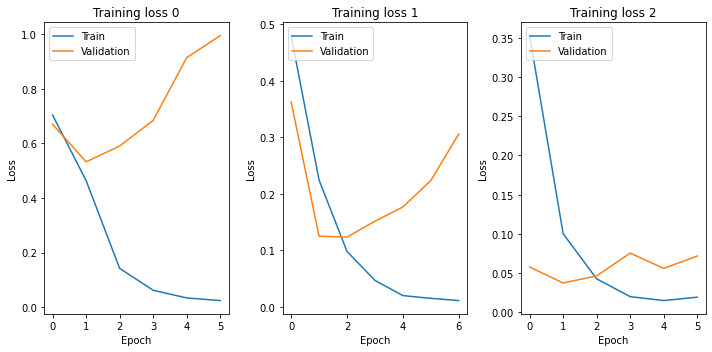

In [79]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=emdedding_size, weights=[vectors], trainable=True)
results, histories = run_test(model_2, X_train, y_train, embedding_layer)
print('Model 2 accuracy on the test data is %.4f' % results[:, 1].mean())

# Plots
# Accuracy
plot_history(histories, 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy') 
# Loss
plot_history(histories, 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss')

In [80]:
# IMDB dataset
from keras.datasets import imdb
word_count = 5000
(X_train_imdb, y_train_imdb), (X_test_imdb, y_test_imdb) = imdb.load_data(num_words=word_count)
max_length = 500
X_train_imdb = sequence.pad_sequences(X_train_imdb, maxlen=max_length)
X_test_imdb = sequence.pad_sequences(X_test_imdb, maxlen=max_length)
X_train_imdb, X_val_imdb, y_train_imdb, y_val_imdb = train_test_split(X_train_imdb, y_train_imdb, random_state=seed, test_size=0.14, stratify=y_train_imdb, shuffle=True)

In [81]:
def model_imdb():
    model = Sequential()
    model.add(Embedding(word_count, 32, input_length=max_length))
    model.add(Conv1D(128, 2))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(64))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer=adamOptimizer, metrics = ['accuracy'])
    return model

Model 2 accuracy on the test data is 0.8746


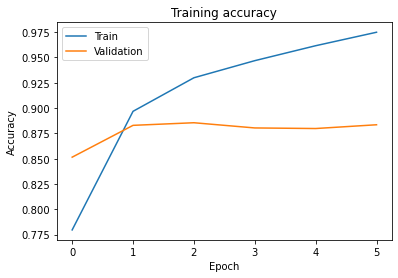

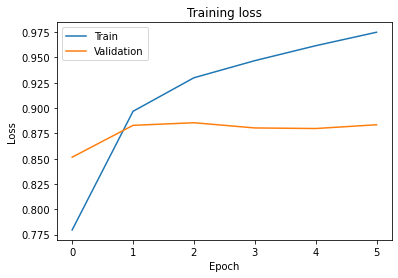

In [82]:
model = model_imdb()
history = model.fit(X_train_imdb, y_train_imdb, validation_data=(X_val_imdb, y_val_imdb), epochs=10, batch_size=64, verbose = 0, callbacks=[early_stopping])
loss, acc = model.evaluate(X_test_imdb, y_test_imdb, verbose = 0, batch_size = 64)
print('Model 2 accuracy on the test data is %.4f' % acc)

# Plots
# Accuracy
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy') 
# Loss
plot_history([history.history], 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss')